In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib
import re as re
import sqlite3

In [47]:
def read_all_tables(connection):
    files_dict = {}
    db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", connection)
    for table in db_tables['name']:
        files_dict[table] = read_table(table, connection)
    return files_dict
def read_table(table_name, connection):
     return pd.read_sql_query("SELECT * from {}".format(table_name), connection)
    
conn = sqlite3.connect('datascience-stackexchange.db')
files_df = read_all_tables(conn)

In [48]:
def top_users(files, sourceDF):
    #top users for posting or commenting
    base_count = files[sourceDF]['UserId'].value_counts().to_frame()
    base_count = base_count.rename(columns={'UserId':'Count'})
    base_count['UserId'] = base_count.index
    base_count['UserId'] = base_count['UserId'].replace('', np.nan)
    base_count.dropna(subset=['UserId'], inplace=True)
    base_count = base_count.reset_index(drop=True)
    files['Users_2'] = files['Users'].rename(columns={'Id': 'UserId'})
    df_merge_col = pd.merge(base_count, files['Users_2'], on='UserId')
    
    return df_merge_col

In [49]:
post_history = files_df['PostHistory'].copy()
post_history.drop(post_history.loc[post_history['PostHistoryTypeId'] != 1].index, inplace=True)

post_count = post_history['UserId'].value_counts().to_frame()
post_count = post_count.rename(columns={'UserId':'Number of Questions Posted'})
post_count['UserId'] = post_count.index
post_count = post_count.reset_index(drop=True)

In [50]:
top_100_user_post = top_users(files_df, 'PostHistory')
post_history = files_df['PostHistory'].copy()
post_history.drop(post_history.loc[post_history['PostHistoryTypeId'] != 1].index, inplace=True)
post_history.drop(post_history.loc[post_history['UserId'] == ''].index, inplace=True)

users_questions = post_history['UserId'].unique()
users_questions = users_questions.astype('int64')

comments = files_df['Comments'].copy()
comment_count = comments['UserId'].value_counts().to_frame()
comment_count = comment_count.rename(columns={'UserId':'Number of Comments Answered'})
comment_count['UserId'] = comment_count.index
comment_count = comment_count.reset_index(drop=True)

In [51]:
comments_per_post_by_userid = pd.merge(post_count, comment_count, on='UserId')
comments_per_post_by_userid.drop(comments_per_post_by_userid.loc[comments_per_post_by_userid['UserId'] == ''].index, inplace=True)
comments_per_post_by_userid['UserId'] = comments_per_post_by_userid['UserId'].astype('int64')
comments_per_post_by_userid = comments_per_post_by_userid.set_index('UserId')
comments_per_post_by_userid['Comments per Post'] = comments_per_post_by_userid['Number of Comments Answered']/comments_per_post_by_userid['Number of Questions Posted']
comments_per_post_by_userid_top_100 = comments_per_post_by_userid[:100]
comments_per_post_by_userid

,Number of Questions Posted,Number of Comments Answered,Comments per Post
UserId,,,
8820,102,267,2.617647
64876,71,242,3.408451
43077,66,101,1.530303
84229,60,69,1.150000
21560,53,34,0.641509
...,...,...,...
6506,1,1,1.000000
8237,1,3,3.000000
99238,1,1,1.000000


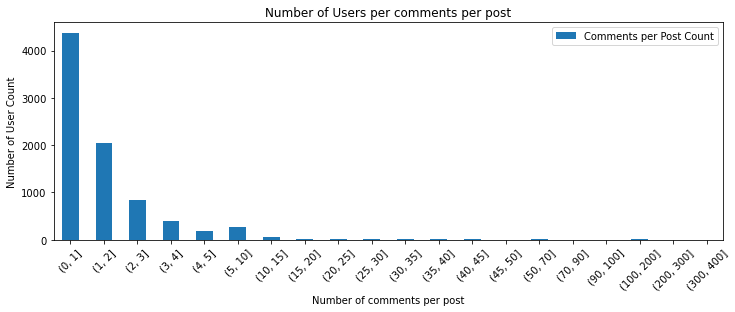

In [52]:
repu_range = np.concatenate((np.arange(0,5,1), np.arange(5,50,5)), axis=None)
repu_range = np.concatenate((repu_range, np.arange(50,100,20)),axis = None)
repu_range = np.concatenate((repu_range, np.arange(100,500,100)),axis = None)

bins = pd.cut(comments_per_post_by_userid['Comments per Post'], repu_range)
comments_per_post_by_userid_grouped = comments_per_post_by_userid.groupby(bins)['Comments per Post'].agg(['count']).rename(columns={'count':'Comments per Post Count'})

comments_per_post_by_userid_grouped.plot(kind="bar", figsize = (12,4))
plt.ylabel("Number of User Count")
plt.xlabel("Number of comments per post")
plt.title("Number of Users per comments per post")
plt.xticks(rotation=45)
plt.savefig('plots/comments-per-post-question-all-val.png', dpi=150, pad_inches = 0.3, bbox_inches='tight')
plt.show()

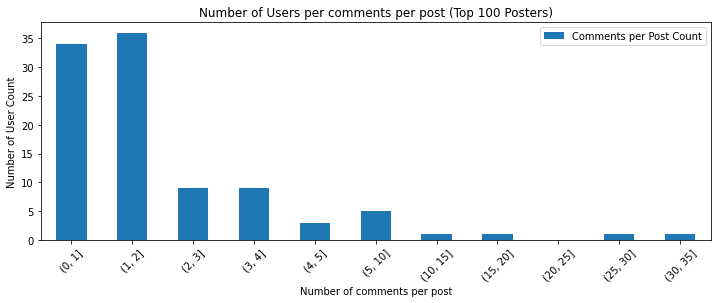

,Comments per Post Count
count,11.000000
mean,9.090909
std,13.201928
min,0.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,36.000000


In [53]:
repu_range = np.concatenate((np.arange(0,5,1), np.arange(5,36,5)), axis=None)
bins = pd.cut(comments_per_post_by_userid_top_100['Comments per Post'], repu_range)
comments_per_post_by_userid_top_100_grouped = comments_per_post_by_userid_top_100.groupby(bins)['Comments per Post'].agg(['count']).rename(columns={'count':'Comments per Post Count'})

comments_per_post_by_userid_top_100_grouped.plot(kind="bar", figsize = (12,4))
plt.ylabel("Number of User Count")
plt.xlabel("Number of comments per post")
plt.title("Number of Users per comments per post (Top 100 Posters)")
plt.xticks(rotation=45)
plt.savefig('plots/comments-per-post-question-0-35.png', dpi=150, pad_inches = 0.3, bbox_inches='tight')
plt.show()

comments_per_post_by_userid_top_100_grouped.describe()


In [42]:
comments_per_post_by_userid.describe()
comments_per_post_by_userid_top_100.describe()
all_mean = comments_per_post_by_userid['Comments per Post'].mean()
top_100_mean = comments_per_post_by_userid_top_100['Comments per Post'].mean()
print ("Comments per post mean: \n Whole PostHistory: %s \n Top 100 posters: %s" %(all_mean, top_100_mean))

Comments per post mean: 
 Whole PostHistory: 2.4826059593578926 
 Top 100 posters: 2.6331328930784066


Yes, the mean for the comments per post of the top 100 users is greater than the mean for the comments per post of all of the users who has at least a comment of and a post.